In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import f1_score
import xgboost as xgb
%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
print("\nNumber of samples:",df.shape[0],"and number of features:",df.shape[1],"\n")
# read the data and display the first 5 rows
df.head()


Number of samples: 45211 and number of features: 17 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.y = (df.y == 'yes').astype(int) #changing our output (y) from categorical to numerical
df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [4]:
df['job'].replace({'admin.': 'admin'}, inplace=True)#cleaning_data

In [5]:
df['balance'] = df['balance'].mask(df['balance'] < 0, 0)

<AxesSubplot:xlabel='balance', ylabel='Count'>

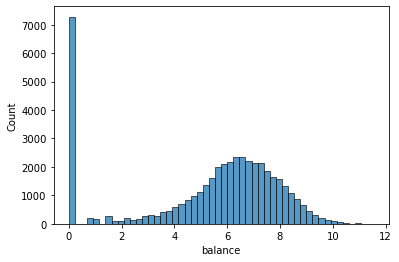

In [6]:
balance_logs = np.log1p(df.balance)
sns.histplot(balance_logs, bins=50)

In [7]:
df['balance_logs'] = balance_logs
df=df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_logs
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,7.670429
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,3.401197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1.098612
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,7.317876
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,0.693147


In [8]:
del df['balance']# we delete balance and replacing it with balance_logs because it will do better in the model.
df=df[['age', 'job', 'marital', 'education', 'default', 'balance_logs', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y']]# reordering DataFrame
df.head()

,age,job,marital,education,default,balance_logs,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,7.670429,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,3.401197,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,1.098612,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,7.317876,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,0.693147,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [9]:
df.balance_logs = df.balance_logs.fillna(0)
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance_logs    0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

In [10]:
df.y.value_counts(normalize=True)

0    0.883015
1    0.116985
Name: y, dtype: float64

In [11]:
numerical = ['age', 'balance_logs', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical  = ['job', 'marital', 'education', 'default',  'housing', 'loan',
       'contact', 'month', 'poutcome']

In [12]:
from sklearn.metrics import mutual_info_score
def mutual_info_churn_score(series):
    return mutual_info_score(series, df.y)
mi = df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

poutcome     0.029397
month        0.024351
contact      0.013627
housing      0.009654
job          0.008264
loan         0.002630
education    0.002598
marital      0.002101
default      0.000294
dtype: float64

In [13]:
corr=df[numerical].corrwith(df.y).abs()
corr.sort_values(ascending=False)

duration        0.394521
pdays           0.103621
balance_logs    0.094435
previous        0.093236
campaign        0.073172
day             0.028348
age             0.025155
dtype: float64

In [14]:
cols = ['age', 'job', 'education', 'balance_logs', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

In [15]:
 #'default', 'marital'

In [16]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

print("samples in the new training subset:",len(df_train))
print("samples in the new test subset:",len(df_val))

samples in the new training subset: 36168
samples in the new test subset: 9043


In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values

In [18]:
from sklearn.feature_extraction import DictVectorizer
train_dict = df_train[cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

test_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(test_dict)

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
model2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

In [21]:
y_pred = model2.predict_proba(X_train)[:, 1]
subscription_decision = (y_pred >= 0.5)
accuracy=(y_train == subscription_decision).mean()
auc=roc_auc_score(y_train, y_pred)
print ('The accuracy = %.4f, auc = %.4f' %(accuracy, auc))

The accuracy = 0.9067, auc = 0.9074


In [22]:
y_pred = model2.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.2)
accuracy=(y_val == subscription_decision).mean()
auc=roc_auc_score(y_val, y_pred)
print ('The accuracy = %.4f, auc = %.4f' %(accuracy, auc))

The accuracy = 0.8671, auc = 0.8995


In [23]:
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.116
0.05 0.669
0.10 0.832
0.15 0.855
0.20 0.867
0.25 0.878
0.30 0.887
0.35 0.890
0.40 0.897
0.45 0.903
0.50 0.900
0.55 0.900
0.60 0.901
0.65 0.898
0.70 0.896
0.75 0.893
0.80 0.888
0.85 0.886
0.90 0.884
0.95 0.884
1.00 0.884


In [24]:
f1_score(y_val, subscription_decision, average='binary')

0.5743626062322946

In [25]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [26]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1050,7993,0,0
10,0.1,870,1339,180,6654
20,0.2,811,963,239,7030
30,0.3,686,658,364,7335
40,0.4,583,462,467,7531
50,0.5,427,277,623,7716
60,0.6,288,130,762,7863
70,0.7,178,64,872,7929
80,0.8,50,12,1000,7981
90,0.9,0,0,1050,7993


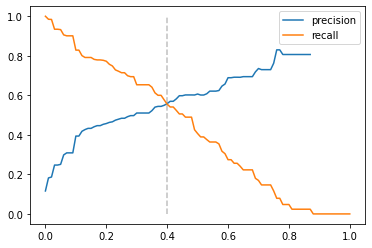

In [27]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

In [28]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)


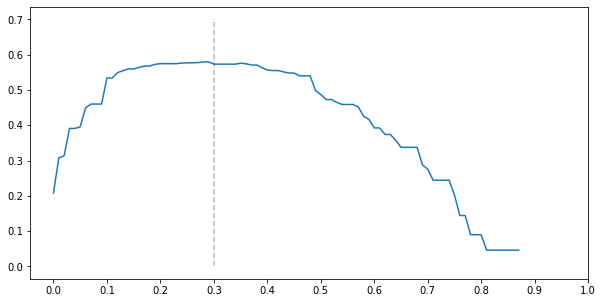

In [29]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### 3.7 XGBoost model.

In [30]:
def parse_xgb_output(output):#extract the output of XGB.train and put it in data frame
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [32]:
scores = {}

In [33]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

**trying basic XGB model and then changing eta [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]**

In [34]:
%%capture output
xgb_params = {
    'eta': 0.01, 
    'max_depth': 7,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

XGB = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,#verbose_eval is used to see what is going on with every 5 models trained
                  evals=watchlist)

In [35]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

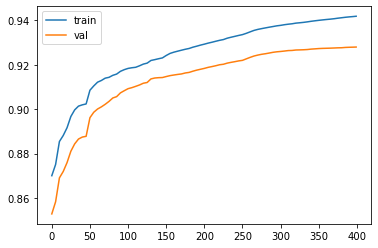

In [36]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [37]:
y_pred1 = XGB.predict(dval)
y_pred2 = XGB.predict(dtrain)

auc1=roc_auc_score(y_val, y_pred1)
auc2=roc_auc_score(y_train, y_pred2)
#f1=f1_score(X_val, y_pred1, average='binary')
#print ('f1= %.3f\t auc_val = %.4f\t, auc_train = %.4f' %(f1, auc1, auc2))
print ('auc_val = %.4f\t, auc_train = %.4f' %(auc1, auc2))



auc_val = 0.9279	, auc_train = 0.9418


In [38]:
%%capture output
xgb_params = {
    'eta': 0.03, 
    'max_depth': 7,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

XGB = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5,
                  evals=watchlist)

In [39]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.03'

In [40]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,
                  evals=watchlist)

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [42]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,
                  evals=watchlist)

In [43]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [44]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,
                  evals=watchlist)

In [45]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [46]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,
                  evals=watchlist)

In [47]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.5'

**Now we plot every model to see its auc_val & auc_train and pick the best one**

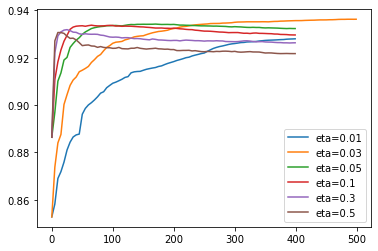

In [48]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

#plt.ylim(0.93, 0.940)
plt.legend()

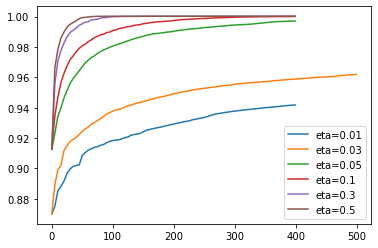

In [49]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.train_auc, label=key)

#plt.ylim(0.93, 0.940)
plt.legend()

**the best with more models trained is 0.03 because it's not overfitting and it achieve the hidghest auc on validation data.**<br>
**the best with less estimators is 0.1 where it learns fast but overfits.**<br>
try eta=0.03,0.1

In [50]:
scores = {}

In [51]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [52]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [53]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [54]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=5'

In [55]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [56]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=8'

In [57]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [58]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

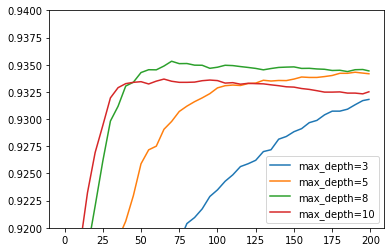

In [59]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.92, 0.940)
plt.legend()

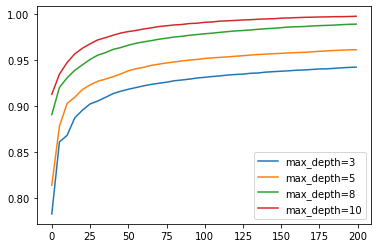

In [60]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.train_auc, label=max_depth)

#plt.ylim(0.91, 0.94)
plt.legend()

the best max_depth is 5

In [61]:
scores = {}

In [62]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [63]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [64]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [65]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [66]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [67]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

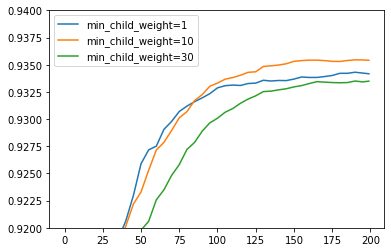

In [68]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.92, 0.94)
plt.legend()

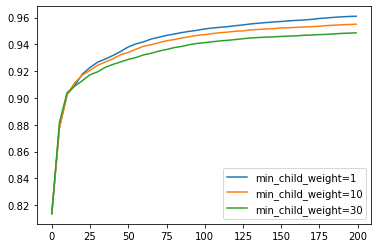

In [69]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.train_auc, label=min_child_weight)

#plt.ylim(0.92, 0.94)
plt.legend()

the best min_child_weight is 10

In [70]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 10,
    'subsample': 0.5,
    'colsample_bytree': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [71]:
key = 'subsample=%s' % (xgb_params['subsample'])
scores[key] = parse_xgb_output(output)
key

'subsample=0.5'

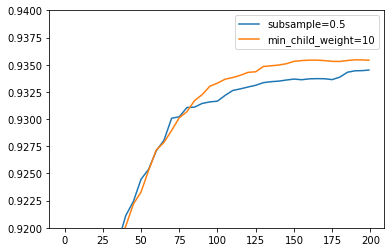

In [72]:
#Here we're comparing our best so far model with subsample=0.5 , its default is subsample=1
subsambles = ['subsample=0.5', 'min_child_weight=10']
for subsample in subsambles:

    
    df_score=scores[subsample]
    plt.plot(df_score.num_iter, df_score.val_auc, label=subsample)

plt.ylim(0.92, 0.94)
plt.legend()

In [73]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 10,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [74]:
key = 'colsample_bytree=%s' % (xgb_params['colsample_bytree'])
scores[key] = parse_xgb_output(output)
key

'colsample_bytree=0.5'

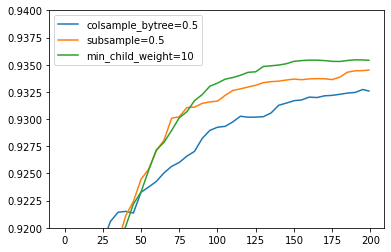

In [75]:
#Here we're comparing our best so far model with 1.subsample=0.5, its default is subsample=1
                                                #2.colsample_bytree=0.5,  its default is colsample_bytree=1

colsample_bytrees = ['colsample_bytree=0.5','subsample=0.5', 'min_child_weight=10']
for colsample_bytree in colsample_bytrees:

    
    df_score=scores[colsample_bytree]
    plt.plot(df_score.num_iter, df_score.val_auc, label=colsample_bytree)

plt.ylim(0.92, 0.94)
plt.legend()

#### still the default parameters are the best for (subsamble & colsample_bytree)